In [1]:
# Импорты
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import math
import random
import json
import os
import re
from datetime import datetime
from collections import Counter
import io
import matplotlib.pyplot as plt

# ----- 1. Конфигурация -----

In [2]:
# Параметры модели
SRC_VOCAB_SIZE = None # Определится после построения словаря
TGT_VOCAB_SIZE = None # Будет таким же, как SRC_VOCAB_SIZE
EMB_SIZE = 256        # Размер эмбеддингов
NHEAD = 4             # Количество голов во multi-head attention
FFN_HID_DIM = 512     # Размер скрытого слоя в FeedForward сети
BATCH_SIZE = 16       # Размер батча для обучения
NUM_ENCODER_LAYERS = 3 # Количество слоев в энкодере
NUM_DECODER_LAYERS = 3 # Количество слоев в декодере
MAX_SEQ_LEN = 512     # Максимальная длина последовательности (увеличьте, если нужно)
DROPOUT = 0.1         # Dropout

# Параметры обучения
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Пути к данным (предполагаем, что у вас есть папка с логами)
# Используйте путь к вашей папке с логами ('YYYY-MM-DD_HH-MM-SS')
DECODED_FILE = '/kaggle/input/json-data-new/2025-03-27_18-31-39_decoded.txt'

# Специальные токены
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX, SEP_IDX = 0, 1, 2, 3, 4
special_symbols = ['<pad>', '<sos>', '<eos>', '<unk>', '<sep>'] # <sep> для разделения контекста и текущего сообщения

# Путь для сохранения/загрузки модели и словаря
MODEL_SAVE_PATH = '/kaggle/working/transformer_repair_model.pth'
VOCAB_SAVE_PATH = '/kaggle/working/vocab.json'
TOKENIZER_SAVE_PATH = '/kaggle/working/tokenizer_config.json'

Using device: cuda


# ----- 2. Подготовка данных -----

In [3]:
# Функция для чтения валидных сообщений
def load_valid_messages(filepath):
    messages = []
    if not os.path.exists(filepath):
        print(f"Warning: File not found {filepath}. Returning empty list.")
        return messages
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    try:
                        # Дополнительная проверка, что это действительно валидный JSON
                        json.loads(line)
                        messages.append(line)
                    except json.JSONDecodeError:
                        # Пропускаем строки, которые не являются валидным JSON, даже если они в decoded.txt
                        # print(f"Skipping invalid JSON in decoded file: {line[:50]}...")
                        pass
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
    print(f"Loaded {len(messages)} valid messages from {filepath}")
    return messages

In [4]:
# Функция для симуляции повреждений
def corrupt_message(message, corruption_prob=0.6):
    if random.random() > corruption_prob: # С некоторой вероятностью не повреждаем
       return message, "no_corruption"

    message_len = len(message)
    if message_len < 5: # Слишком короткое для повреждения
        return message, "too_short"

    corruption_type = random.choice(['missing_start', 'missing_end', 'missing_middle', 'char_change', 'missing_start_end'])

    if corruption_type == 'missing_start':
        cut_point = random.randint(1, max(1, message_len // 2))
        return message[cut_point:], corruption_type
    elif corruption_type == 'missing_end':
        cut_point = random.randint(max(1, message_len // 2), message_len - 1)
        return message[:cut_point], corruption_type
    elif corruption_type == 'missing_middle':
        start_cut = random.randint(1, max(1, message_len // 3))
        end_cut = random.randint(start_cut + 1, max(start_cut + 2, message_len * 2 // 3))
        if start_cut < len(message) and end_cut < len(message):
             return message[:start_cut] + message[end_cut:], corruption_type
        else:
             return message, "failed_middle_cut" # Неудачное повреждение
    elif corruption_type == 'char_change':
        num_changes = random.randint(1, max(1, message_len // 10)) # Меняем до 10% символов
        msg_list = list(message)
        possible_chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,:;{}[]"\'?!@#$%^&*()_-+=<>~`|\\'
        for _ in range(num_changes):
            idx_to_change = random.randint(0, message_len - 1)
            # Меняем на случайный символ, кроме исходного
            original_char = msg_list[idx_to_change]
            new_char = random.choice(possible_chars)
            while new_char == original_char:
                new_char = random.choice(possible_chars)
            msg_list[idx_to_change] = new_char
        return "".join(msg_list), corruption_type
    elif corruption_type == 'missing_start_end':
        start_cut = random.randint(1, max(1, message_len // 3))
        end_cut = random.randint(max(1, message_len * 2 // 3), message_len -1)
        if start_cut < end_cut and start_cut < len(message) and end_cut < len(message):
            return message[start_cut:end_cut], corruption_type
        else:
            # Если точки среза неудачные, делаем просто отрезание начала
             cut_point = random.randint(1, max(1, message_len // 2))
             return message[cut_point:], "missing_start" # Fallback

    return message, "unknown_corruption_type" # На всякий случай

In [5]:
# --- Словари и Токенизация ---
class CharacterTokenizer:
    def __init__(self, special_symbols):
        self.char2idx = {}
        self.idx2char = {}
        self.special_symbols = special_symbols
        self._build_vocab([]) # Инициализация со спец. символами

    def _build_vocab(self, texts):
        all_chars = Counter()
        for text in texts:
            all_chars.update(text)

        self.char2idx = {char: i for i, char in enumerate(special_symbols)}
        for char, _ in all_chars.most_common():
            if char not in self.char2idx:
                self.char2idx[char] = len(self.char2idx)
        self.idx2char = {i: char for char, i in self.char2idx.items()}

        # Обновляем глобальные переменные размера словаря
        global SRC_VOCAB_SIZE, TGT_VOCAB_SIZE
        SRC_VOCAB_SIZE = len(self.char2idx)
        TGT_VOCAB_SIZE = SRC_VOCAB_SIZE
        print(f"Vocabulary size: {SRC_VOCAB_SIZE}")
        print(f"Sample vocab mapping: {list(self.char2idx.items())[:10]}...")


    def build_vocab_from_file(self, filepath):
         valid_messages = load_valid_messages(filepath)
         if valid_messages:
             self._build_vocab(valid_messages)
         else:
             print("Warning: No valid messages found to build vocabulary.")

    def encode(self, text, add_special_tokens=True):
        tokens = [self.char2idx.get(char, UNK_IDX) for char in text]
        if add_special_tokens:
            return [SOS_IDX] + tokens + [EOS_IDX]
        return tokens

    def decode(self, token_ids, remove_special_tokens=True):
        chars = []
        for token_id in token_ids:
            if remove_special_tokens and token_id in [PAD_IDX, SOS_IDX, EOS_IDX, SEP_IDX]:
                continue
            chars.append(self.idx2char.get(token_id, '<unk>')) # Используем <unk> для неизвестных ID
        return "".join(chars)

    def save(self, vocab_path, config_path):
        with open(vocab_path, 'w', encoding='utf-8') as f:
            json.dump({'char2idx': self.char2idx, 'idx2char': self.idx2char}, f, ensure_ascii=False, indent=4)
        with open(config_path, 'w', encoding='utf-8') as f:
            json.dump({'special_symbols': self.special_symbols,
                       'pad_idx': PAD_IDX, 'sos_idx': SOS_IDX, 'eos_idx': EOS_IDX,
                       'unk_idx': UNK_IDX, 'sep_idx': SEP_IDX}, f, indent=4)

    @classmethod
    def load(cls, vocab_path, config_path):
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)
        instance = cls(config['special_symbols'])

        with open(vocab_path, 'r', encoding='utf-8') as f:
            vocabs = json.load(f)
            # JSON ключи словарей могут быть строками, преобразуем обратно в int для idx2char
            instance.char2idx = vocabs['char2idx']
            instance.idx2char = {int(k): v for k, v in vocabs['idx2char'].items()}

        # Обновляем глобальные переменные размера словаря
        global SRC_VOCAB_SIZE, TGT_VOCAB_SIZE
        SRC_VOCAB_SIZE = len(instance.char2idx)
        TGT_VOCAB_SIZE = SRC_VOCAB_SIZE

        # Убедимся, что глобальные IDX константы соответствуют загруженным
        global PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX, SEP_IDX
        PAD_IDX = config['pad_idx']
        SOS_IDX = config['sos_idx']
        EOS_IDX = config['eos_idx']
        UNK_IDX = config['unk_idx']
        SEP_IDX = config['sep_idx']

        print(f"Loaded tokenizer. Vocabulary size: {SRC_VOCAB_SIZE}")
        return instance

In [6]:
# --- Создание датасета ---
class JsonRepairDataset(Dataset):
    def __init__(self, valid_messages, tokenizer, max_len=MAX_SEQ_LEN, corruption_prob=0.7):
        self.valid_messages = valid_messages
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.corruption_prob = corruption_prob
        self.data = self._prepare_data()

    def _prepare_data(self):
        prepared = []
        last_valid_msg = "" # Начинаем без контекста
        for i, current_valid_msg in enumerate(self.valid_messages):
            # Создаем поврежденную версию текущего сообщения
            corrupted_msg, _ = corrupt_message(current_valid_msg, self.corruption_prob)

            # Создаем входную последовательность: контекст + <sep> + поврежденное сообщение
            # Не добавляем спец. токены SOS/EOS здесь, токенизатор сделает это для target
            # А для src мы сделаем это вручную с SEP
            context_tokens = self.tokenizer.encode(last_valid_msg, add_special_tokens=False) if last_valid_msg else []
            corrupted_tokens = self.tokenizer.encode(corrupted_msg, add_special_tokens=False)

            # Формируем src с разделителем
            src_tokens = context_tokens + [SEP_IDX] + corrupted_tokens
            # Обрезаем, если слишком длинно (оставляем конец)
            src_tokens = src_tokens[-(self.max_len - 2):] # -2 для будущих SOS/EOS если бы они были нужны, или просто запас
            src_tokens = torch.tensor(src_tokens, dtype=torch.long)

            # Target - это исходное валидное сообщение с SOS/EOS
            tgt_tokens = self.tokenizer.encode(current_valid_msg, add_special_tokens=True)
            # Обрезаем target если нужно
            tgt_tokens = tgt_tokens[:self.max_len]
            tgt_tokens = torch.tensor(tgt_tokens, dtype=torch.long)


            prepared.append({'src': src_tokens, 'tgt': tgt_tokens})

            # Обновляем контекст для следующей итерации
            last_valid_msg = current_valid_msg

        print(f"Prepared {len(prepared)} data pairs.")
        return prepared

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
# --- Функция для паддинга батчей ---
def generate_batch(data_batch):
    src_batch, tgt_batch = [], []
    for item in data_batch:
        src_batch.append(item['src'])
        tgt_batch.append(item['tgt'])

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True) # batch_first=True для Transformer
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

# --- 3. Определение Модели Трансформера ---

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(0) # Добавим batch dimension в начале

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding) # Не параметр модели

    def forward(self, token_embedding: torch.Tensor):
        # token_embedding: [batch_size, seq_len, emb_size]
        # self.pos_embedding[:, :token_embedding.size(1)] -> [1, seq_len, emb_size]
        seq_len = token_embedding.size(1)
        pos_emb = self.pos_embedding[:, :seq_len]
        # Убедимся, что размер совпадает перед сложением
        # print(f"Token emb shape: {token_embedding.shape}")
        # print(f"Positional emb shape: {pos_emb.shape}")
        if pos_emb.shape[1] != seq_len:
             # Этого не должно происходить при правильном maxlen, но на всякий случай
             raise ValueError(f"Positional embedding sequence length ({pos_emb.shape[1]}) does not match input sequence length ({seq_len}). Increase maxlen in PositionalEncoding.")

        return self.dropout(token_embedding + pos_emb)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [9]:
# --- Основная модель Seq2Seq Transformer ---
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1,
                 max_seq_len: int = MAX_SEQ_LEN): # max_seq_len для PositionalEncoding
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True) # Важно: batch_first=True
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout, maxlen=max_seq_len) # Используем max_seq_len

    def forward(self,
                src: torch.Tensor,
                trg: torch.Tensor,
                src_padding_mask: torch.Tensor,
                tgt_padding_mask: torch.Tensor,
                memory_key_padding_mask: torch.Tensor,
                tgt_mask: torch.Tensor):
        # src: [batch_size, src_seq_len]
        # trg: [batch_size, tgt_seq_len]
        # src_padding_mask: [batch_size, src_seq_len]
        # tgt_padding_mask: [batch_size, tgt_seq_len]
        # memory_key_padding_mask: [batch_size, src_seq_len] (обычно совпадает с src_padding_mask)
        # tgt_mask: [tgt_seq_len, tgt_seq_len]

        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        # src_emb: [batch_size, src_seq_len, emb_size]
        # tgt_emb: [batch_size, tgt_seq_len, emb_size]

        # print(f"src_emb shape: {src_emb.shape}")
        # print(f"tgt_emb shape: {tgt_emb.shape}")
        # print(f"tgt_mask shape: {tgt_mask.shape}")
        # print(f"src_padding_mask shape: {src_padding_mask.shape}")
        # print(f"tgt_padding_mask shape: {tgt_padding_mask.shape}")
        # print(f"memory_key_padding_mask shape: {memory_key_padding_mask.shape}")


        outs = self.transformer(src_emb, tgt_emb,
                                tgt_mask=tgt_mask,
                                src_key_padding_mask=src_padding_mask,
                                tgt_key_padding_mask=tgt_padding_mask,
                                memory_key_padding_mask=memory_key_padding_mask)
        # outs: [batch_size, tgt_seq_len, emb_size]
        return self.generator(outs) # [batch_size, tgt_seq_len, tgt_vocab_size]

    def encode(self, src: torch.Tensor, src_mask: torch.Tensor):
        # src: [batch_size, src_seq_len]
        # src_mask: [src_seq_len, src_seq_len] (треугольная, не используется стандартно в encode)
        # src_padding_mask генерируется внутри или передается
        src_padding_mask = (src == PAD_IDX) # [batch_size, src_seq_len]
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        # print(f"Encode src_emb shape: {src_emb.shape}")
        # print(f"Encode src_padding_mask shape: {src_padding_mask.shape}")
        return self.transformer.encoder(src_emb, src_key_padding_mask=src_padding_mask) # [batch_size, src_seq_len, emb_size]

    def decode(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_mask: torch.Tensor, tgt_padding_mask: torch.Tensor, memory_key_padding_mask: torch.Tensor):
        # tgt: [batch_size, tgt_seq_len]
        # memory: [batch_size, src_seq_len, emb_size] (output of encoder)
        # tgt_mask: [tgt_seq_len, tgt_seq_len]
        # tgt_padding_mask: [batch_size, tgt_seq_len]
        # memory_key_padding_mask: [batch_size, src_seq_len]

        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        # print(f"Decode tgt_emb shape: {tgt_emb.shape}")
        # print(f"Decode memory shape: {memory.shape}")
        # print(f"Decode tgt_mask shape: {tgt_mask.shape}")
        # print(f"Decode tgt_padding_mask shape: {tgt_padding_mask.shape}")
        # print(f"Decode memory_key_padding_mask shape: {memory_key_padding_mask.shape}")

        return self.transformer.decoder(tgt_emb, memory,
                                        tgt_mask=tgt_mask,
                                        tgt_key_padding_mask=tgt_padding_mask,
                                        memory_key_padding_mask=memory_key_padding_mask) # [batch_size, tgt_seq_len, emb_size]


In [10]:
# --- Вспомогательные функции для масок ---
def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask # [sz, sz]

def create_mask(src, tgt, device):
    # src: [batch_size, src_seq_len]
    # tgt: [batch_size, tgt_seq_len]
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    # Маска для декодера, чтобы он не смотрел вперед
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device) # [tgt_seq_len, tgt_seq_len]

    # Маски для паддинга
    # True там, где PAD_IDX
    src_padding_mask = (src == PAD_IDX) # [batch_size, src_seq_len]
    tgt_padding_mask = (tgt == PAD_IDX) # [batch_size, tgt_seq_len]

    # memory_key_padding_mask используется декодером для игнорирования паддинга в output энкодера (memory)
    # Обычно она такая же, как src_padding_mask
    memory_key_padding_mask = src_padding_mask # [batch_size, src_seq_len]

    return src_padding_mask, tgt_padding_mask, memory_key_padding_mask, tgt_mask

# ----- 4. Обучение -----

# --- Инициализация ---

In [11]:
# Создаем или загружаем токенизатор
if os.path.exists(VOCAB_SAVE_PATH) and os.path.exists(TOKENIZER_SAVE_PATH):
    print("Loading existing tokenizer...")
    tokenizer = CharacterTokenizer.load(VOCAB_SAVE_PATH, TOKENIZER_SAVE_PATH)
else:
    print("Building tokenizer from scratch...")
    tokenizer = CharacterTokenizer(special_symbols)
    # Убедитесь, что DECODED_FILE существует и содержит данные
    if os.path.exists(DECODED_FILE):
        tokenizer.build_vocab_from_file(DECODED_FILE)
        tokenizer.save(VOCAB_SAVE_PATH, TOKENIZER_SAVE_PATH)
    else:
        raise FileNotFoundError(f"Cannot build vocabulary: {DECODED_FILE} not found.")


Building tokenizer from scratch...
Vocabulary size: 5
Sample vocab mapping: [('<pad>', 0), ('<sos>', 1), ('<eos>', 2), ('<unk>', 3), ('<sep>', 4)]...
Loaded 15905 valid messages from /kaggle/input/json-data-new/2025-03-27_18-31-39_decoded.txt
Vocabulary size: 43
Sample vocab mapping: [('<pad>', 0), ('<sos>', 1), ('<eos>', 2), ('<unk>', 3), ('<sep>', 4), ('"', 5), (':', 6), (',', 7), ('0', 8), ('.', 9)]...


In [12]:
# Загрузка данных
valid_messages = load_valid_messages(DECODED_FILE)
if not valid_messages:
     raise ValueError(f"No valid messages loaded from {DECODED_FILE}. Cannot train.")

Loaded 15905 valid messages from /kaggle/input/json-data-new/2025-03-27_18-31-39_decoded.txt


In [13]:
# Разделение на train/validation (например, 90/10)
random.shuffle(valid_messages)
split_idx = int(len(valid_messages) * 0.9)
train_messages = valid_messages[:split_idx]
val_messages = valid_messages[split_idx:]

train_dataset = JsonRepairDataset(train_messages, tokenizer, max_len=MAX_SEQ_LEN, corruption_prob=0.7)
val_dataset = JsonRepairDataset(val_messages, tokenizer, max_len=MAX_SEQ_LEN, corruption_prob=0.5) # Можно меньше портить для валидации

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

Prepared 14314 data pairs.
Prepared 1591 data pairs.


# --- Инициализация модели ---

In [14]:
if SRC_VOCAB_SIZE is None or TGT_VOCAB_SIZE is None:
     raise ValueError("Vocabulary size not set. Ensure tokenizer was built or loaded.")

transformer_model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROPOUT, MAX_SEQ_LEN)

# Переносим модель на нужное устройство
transformer_model = transformer_model.to(DEVICE)

# Инициализация весов (может улучшить сходимость)
for p in transformer_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Loss и Optimizer
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX) # Игнорируем паддинг при подсчете лосса
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

epoch_list = []
train_loss_list = []
val_loss_list = []

# --- Цикл обучения ---
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    processed_batches = 0
    for src, tgt in dataloader:
        src = src.to(device) # [batch_size, src_seq_len]
        tgt = tgt.to(device) # [batch_size, tgt_seq_len]

        # Подготовка входов для декодера
        # tgt_input используется как вход декодера (все кроме последнего токена <eos>)
        tgt_input = tgt[:, :-1] # [batch_size, tgt_seq_len - 1]
        # tgt_out используется как цель (все кроме первого токена <sos>)
        tgt_out = tgt[:, 1:]   # [batch_size, tgt_seq_len - 1]

        # Создание масок
        src_padding_mask, tgt_padding_mask, memory_key_padding_mask, tgt_mask = create_mask(src, tgt_input, device)
        # tgt_padding_mask нужно создать для tgt_input
        tgt_padding_mask = (tgt_input == PAD_IDX) # [batch_size, tgt_seq_len - 1]

        # print("--- Train Batch Shapes ---")
        # print(f"src: {src.shape}")
        # print(f"tgt_input: {tgt_input.shape}")
        # print(f"tgt_out: {tgt_out.shape}")
        # print(f"src_padding_mask: {src_padding_mask.shape}")
        # print(f"tgt_padding_mask (for input): {tgt_padding_mask.shape}")
        # print(f"memory_key_padding_mask: {memory_key_padding_mask.shape}")
        # print(f"tgt_mask: {tgt_mask.shape}")

        # Forward pass
        logits = model(src, tgt_input, src_padding_mask, tgt_padding_mask, memory_key_padding_mask, tgt_mask)
        # logits: [batch_size, tgt_seq_len - 1, tgt_vocab_size]

        optimizer.zero_grad()

        # Расчет лосса
        # Нужно изменить размерность logits и tgt_out для CrossEntropyLoss
        # logits -> [batch_size * (tgt_seq_len - 1), tgt_vocab_size]
        # tgt_out -> [batch_size * (tgt_seq_len - 1)]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        processed_batches += 1
        if processed_batches % 50 == 0: # Логгирование каждые 50 батчей
             print(f"  Batch {processed_batches}/{len(dataloader)}, Current Loss: {loss.item():.4f}")

    return total_loss / len(dataloader)

# --- Цикл валидации ---
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_out = tgt[:, 1:]

            src_padding_mask, tgt_padding_mask, memory_key_padding_mask, tgt_mask = create_mask(src, tgt_input, device)
            tgt_padding_mask = (tgt_input == PAD_IDX) # Маска для tgt_input

            logits = model(src, tgt_input, src_padding_mask, tgt_padding_mask, memory_key_padding_mask, tgt_mask)

            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
# --- Запуск обучения ---
print("\nStarting training...")
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = datetime.now()
    train_loss = train_epoch(transformer_model, train_dataloader, optimizer, loss_fn, DEVICE)
    val_loss = evaluate(transformer_model, val_dataloader, loss_fn, DEVICE)
    end_time = datetime.now()

    print(f"Epoch {epoch}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {end_time - start_time}")

    epoch_list.append(epoch)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    # Сохранение лучшей модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
            'params': { # Сохраняем параметры для будущей загрузки
                 'num_encoder_layers': NUM_ENCODER_LAYERS,
                 'num_decoder_layers': NUM_DECODER_LAYERS,
                 'emb_size': EMB_SIZE,
                 'nhead': NHEAD,
                 'src_vocab_size': SRC_VOCAB_SIZE,
                 'tgt_vocab_size': TGT_VOCAB_SIZE,
                 'dim_feedforward': FFN_HID_DIM,
                 'dropout': DROPOUT,
                 'max_seq_len': MAX_SEQ_LEN
            }
        }, MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH}")

print("Training finished.")


Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


  Batch 50/895, Current Loss: 1.8501
  Batch 100/895, Current Loss: 1.2786
  Batch 150/895, Current Loss: 1.0696
  Batch 200/895, Current Loss: 0.8890
  Batch 250/895, Current Loss: 0.7991
  Batch 300/895, Current Loss: 0.7245
  Batch 350/895, Current Loss: 0.7069
  Batch 400/895, Current Loss: 0.6904
  Batch 450/895, Current Loss: 0.7128
  Batch 500/895, Current Loss: 0.6274
  Batch 550/895, Current Loss: 0.6441
  Batch 600/895, Current Loss: 0.6011
  Batch 650/895, Current Loss: 0.5500
  Batch 700/895, Current Loss: 0.5744
  Batch 750/895, Current Loss: 0.5308
  Batch 800/895, Current Loss: 0.5444
  Batch 850/895, Current Loss: 0.5383


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/20, Train Loss: 0.8449, Val Loss: 0.4705, Time: 0:02:14.869160
Model saved to /kaggle/working/transformer_repair_model.pth
  Batch 50/895, Current Loss: 0.5810
  Batch 100/895, Current Loss: 0.5106
  Batch 150/895, Current Loss: 0.4814
  Batch 200/895, Current Loss: 0.5182
  Batch 250/895, Current Loss: 0.4791
  Batch 300/895, Current Loss: 0.4904
  Batch 350/895, Current Loss: 0.4894
  Batch 400/895, Current Loss: 0.4926
  Batch 450/895, Current Loss: 0.4815
  Batch 500/895, Current Loss: 0.4409
  Batch 550/895, Current Loss: 0.5093
  Batch 600/895, Current Loss: 0.4339
  Batch 650/895, Current Loss: 0.4330
  Batch 700/895, Current Loss: 0.4175
  Batch 750/895, Current Loss: 0.4484
  Batch 800/895, Current Loss: 0.4767
  Batch 850/895, Current Loss: 0.4369
Epoch 2/20, Train Loss: 0.4795, Val Loss: 0.3979, Time: 0:02:19.088096
Model saved to /kaggle/working/transformer_repair_model.pth
  Batch 50/895, Current Loss: 0.4222
  Batch 100/895, Current Loss: 0.4307
  Batch 150/895, C


Plotting losses...


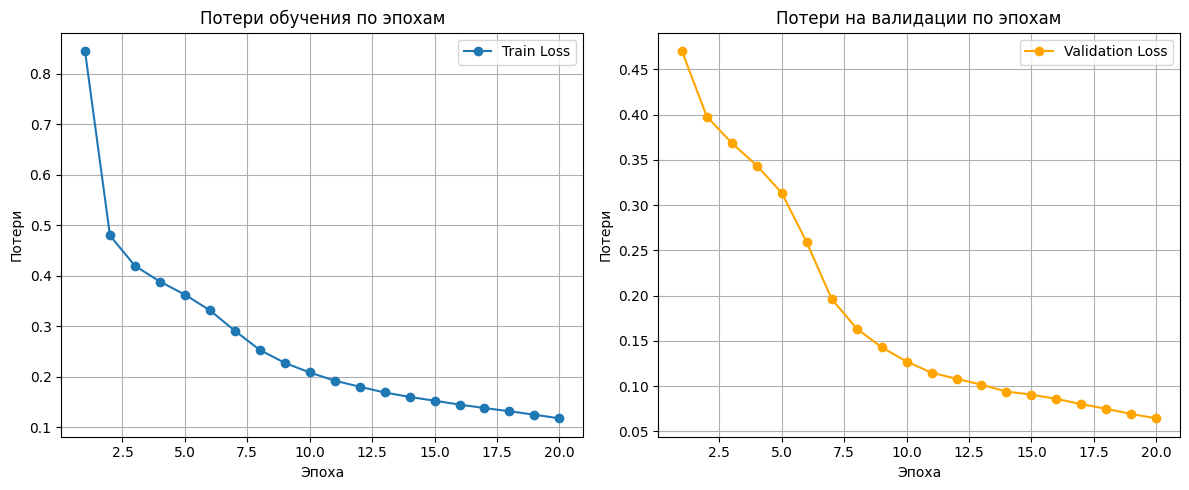

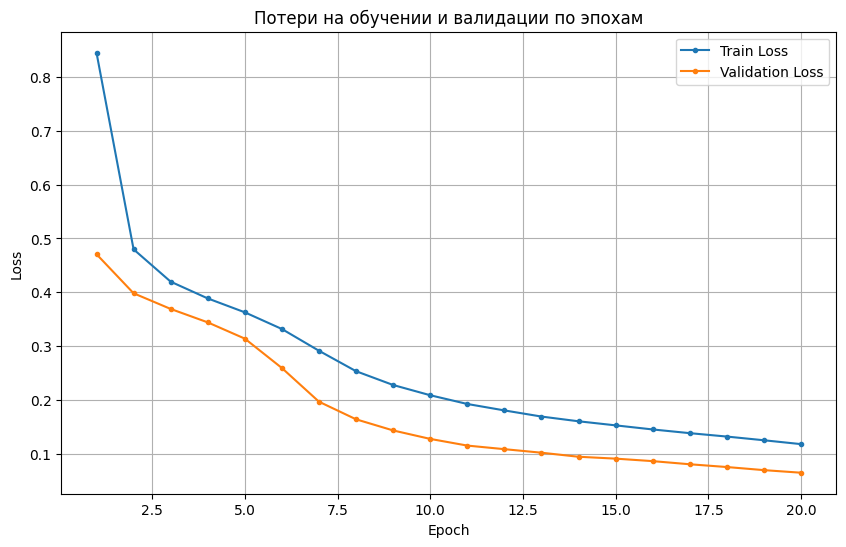

Plotting finished.


In [21]:
# --- Построение графиков потерь ---
print("\nPlotting losses...")

plt.figure(figsize=(12, 5))

# График 1: Train Loss
plt.subplot(1, 2, 1) # 1 строка, 2 колонки, 1-й график
plt.plot(epoch_list, train_loss_list, label='Train Loss', marker='o')
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Потери обучения по эпохам")
plt.legend()
plt.grid(True)

# График 2: Validation Loss
plt.subplot(1, 2, 2) # 1 строка, 2 колонки, 2-й график
plt.plot(epoch_list, val_loss_list, label='Validation Loss', color='orange', marker='o')
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Потери на валидации по эпохам")
plt.legend()
plt.grid(True)

plt.tight_layout() # Чтобы графики не перекрывались
plt.savefig("losses_separate.png")
plt.show()

# Опционально: График совмещенных потерь
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, train_loss_list, label='Train Loss', marker='.')
plt.plot(epoch_list, val_loss_list, label='Validation Loss', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Потери на обучении и валидации по эпохам")
plt.legend()
plt.grid(True)
plt.savefig("losses_combined.png")
plt.show()

print("Plotting finished.")

# ----- 5. Использование (Инференс) -----

In [17]:
# Функция для декодирования последовательности (Greedy Decode)
def greedy_decode(model, src, src_padding_mask, max_len, start_symbol_idx, end_symbol_idx, device):
    model.eval()
    src = src.to(device)
    src_padding_mask = src_padding_mask.to(device)

    with torch.no_grad():
        # Энкодер вызывается один раз
        memory = model.encode(src, None) # src_mask не нужен для энкодера здесь
        # memory: [batch_size, src_seq_len, emb_size]
        memory = memory.to(device)
        # memory_key_padding_mask нужен для декодера
        memory_key_padding_mask = src_padding_mask # [batch_size, src_seq_len]

        # Инициализация выходной последовательности для декодера (начинаем с SOS)
        # Добавляем batch dimension = 1
        ys = torch.ones(1, 1).fill_(start_symbol_idx).type(torch.long).to(device) # [1, 1]

        for i in range(max_len - 1):
            # Получаем маску для текущей длины выходной последовательности
            tgt_seq_len = ys.shape[1]
            tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device).to(device) # [tgt_seq_len, tgt_seq_len]
            # Паддинг маска для выхода не нужна, т.к. генерируем по одному токену
            tgt_padding_mask = torch.zeros(ys.shape, dtype=torch.bool).to(device) # [1, tgt_seq_len]

            # Декодируем
            # print(f"\nDecode Step {i}:")
            # print(f" ys shape: {ys.shape}")
            # print(f" memory shape: {memory.shape}")
            # print(f" tgt_mask shape: {tgt_mask.shape}")
            # print(f" tgt_padding_mask shape: {tgt_padding_mask.shape}")
            # print(f" memory_key_padding_mask shape: {memory_key_padding_mask.shape}")

            out = model.decode(ys, memory, tgt_mask, tgt_padding_mask=tgt_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
            # out: [batch_size=1, current_tgt_seq_len, emb_size]
            # Берем последний выход по времени
            out = out[:, -1, :] # [1, emb_size]
            # Преобразуем в вероятности токенов
            prob = model.generator(out) # [1, tgt_vocab_size]
            # Выбираем самый вероятный токен (Greedy)
            _, next_word_idx = torch.max(prob, dim=1)
            next_word_idx = next_word_idx.item()

            # Добавляем предсказанный токен к последовательности
            ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word_idx)], dim=1)

            # Если предсказан EOS, завершаем
            if next_word_idx == end_symbol_idx:
                break

    # Убираем SOS токен из результата
    return ys[0, 1:] # Возвращаем тензор токенов без batch dimension и без SOS

In [18]:
# --- Функция для восстановления сообщения ---
def reconstruct_message(corrupted_msg: str, last_valid_msg: str, model: Seq2SeqTransformer, tokenizer: CharacterTokenizer, device: torch.device, max_len: int = MAX_SEQ_LEN):
    """
    Восстанавливает поврежденное сообщение, используя модель и контекст.

    Args:
        corrupted_msg: Поврежденная строка сообщения.
        last_valid_msg: Последнее известное валидное сообщение (контекст).
        model: Обученная модель Seq2SeqTransformer.
        tokenizer: Обученный CharacterTokenizer.
        device: Устройство (cpu или cuda).
        max_len: Максимальная длина генерируемой последовательности.

    Returns:
        Строка с восстановленным сообщением или None, если восстановление не удалось.
    """
    model.eval() # Переключаем модель в режим инференса

    # 1. Подготовка входных данных
    context_tokens = tokenizer.encode(last_valid_msg, add_special_tokens=False) if last_valid_msg else []
    corrupted_tokens = tokenizer.encode(corrupted_msg, add_special_tokens=False)
    src_tokens = context_tokens + [SEP_IDX] + corrupted_tokens
    src_tokens = src_tokens[-(max_len-2):] # Обрезаем если нужно
    src_tensor = torch.tensor([src_tokens], dtype=torch.long).to(device) # Добавляем batch dimension

    # 2. Создание паддинг маски для входа
    # False там, где реальные токены, True там, где паддинг (здесь паддинга нет, т.к. 1 пример)
    src_padding_mask = torch.zeros(src_tensor.shape, dtype=torch.bool).to(device)

    # 3. Генерация выходной последовательности
    generated_token_ids = greedy_decode(
        model,
        src_tensor,
        src_padding_mask,
        max_len=max_len,
        start_symbol_idx=SOS_IDX,
        end_symbol_idx=EOS_IDX,
        device=device
    )
    # print(generated_token_ids.cpu().numpy())
    # 4. Декодирование токенов в строку
    reconstructed_msg = tokenizer.decode(generated_token_ids.cpu().numpy(), remove_special_tokens=True)

    # 5. Валидация JSON (опционально, но рекомендуется)
    try:
        json.loads(reconstructed_msg)
        print(f"Reconstruction successful and valid JSON.")
        return reconstructed_msg
    except json.JSONDecodeError as e:
        print(f"Reconstruction produced invalid JSON: {e}")
        print(f"Raw reconstructed output: {reconstructed_msg}")
        # Возможно, стоит вернуть сырой вывод, если валидация не прошла,
        # или None, чтобы показать неудачу. Зависит от требований.
        return reconstructed_msg # Возвращаем даже если невалидный JSON, чтобы посмотреть

# --- Пример использования ---

# Загрузка обученной модели и токенизатора (если не в той же сессии)
if 'transformer_model' not in locals(): # Если модель не определена
    print("Loading model and tokenizer for inference...")
    # Загрузка токенизатора
    tokenizer = CharacterTokenizer.load(VOCAB_SAVE_PATH, TOKENIZER_SAVE_PATH)
    # Загрузка параметров модели из чекпоинта
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
    model_params = checkpoint['params']
    # Создание модели с сохраненными параметрами
    transformer_model = Seq2SeqTransformer(
        num_encoder_layers=model_params['num_encoder_layers'],
        num_decoder_layers=model_params['num_decoder_layers'],
        emb_size=model_params['emb_size'],
        nhead=model_params['nhead'],
        src_vocab_size=model_params['src_vocab_size'],
        tgt_vocab_size=model_params['tgt_vocab_size'],
        dim_feedforward=model_params['dim_feedforward'],
        dropout=model_params['dropout'],
        max_seq_len=model_params['max_seq_len']
    )
    # Загрузка весов
    transformer_model.load_state_dict(checkpoint['model_state_dict'])
    transformer_model.to(DEVICE)
    transformer_model.eval() # Важно перевести в режим eval
    print(f"Model loaded from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")

# --- Симуляция получения данных ---

In [19]:
# Предположим, у нас есть история валидных сообщений
history_valid = [
    '{"pc":24,"pres":100809,"t":25.41903,"h":17.37219,"lat":40.52597,"lng":60.56058,"galt":33.9,"c":151}',
'{"dr":0.06,"ad":0.31,"td":21,"bat":73,"dt":21.4,"dh":34.3,"mps":0.56,"deg":218.13,"chyx":102.84,"chzx":282.39,"tx":0.3,"ty":2.2,"tz":-6.81,"tb":26.6,"alt":0.836734,"salt":43.04918,"cx":-4,"cy":983,"cz":-1083,"gx":-0.84,"gy":-0.05,"gz":0.05,"ax":0.05,"ay":0.01,"az":1.21,"gs":49,"hdop":9.53,"sc":5,"d":27,"mh":3,"y":2025,"hr":15,"m":50,"s":27,"u":5.02,"i":0.8,"p":4.01,"c":151}',
'{"pc":20,"pres":100811,"t":25.41903,"h":17.37219,"lat":40.5261,"lng":60.56082,"galt":30.8,"c":152}',
'{"dr":0.05,"ad":0.31,"td":21,"bat":73,"dt":21.4,"dh":34.3,"mps":0.01,"deg":217.54,"chyx":102.84,"chzx":282.39,"tx":0.28,"ty":2.2,"tz":-6.86,"tb":26.6,"alt":0.669281,"salt":42.88206,"cx":-4,"cy":983,"cz":-1083,"gx":-0.85,"gy":-0.05,"gz":0.05,"ax":0.05,"ay":0.01,"az":1.2,"gs":49,"hdop":9.51,"sc":5,"d":27,"mh":3,"y":2025,"hr":15,"m":50,"s":34,"u":4.94,"i":0.8,"p":3.95,"c":152}'

]
last_known_valid_message = history_valid[-1] # Последнее длинное сообщение

# Пример 1: Повреждено короткое сообщение (нет конца)
corrupted_short = '{"pc":34,"pres":100814,"t":25.41903,"h":17.37219,"lat":40.52617'
expected_short = '{"pc":34,"pres":100814,"t":25.41903,"h":17.37219,"lat":40.52617,"lng":60.56099,"galt":28.2,"c":153}' # Что мы ожидаем

print("\n--- Example 1: Corrupted Short Message ---")
print(f"Last Valid: {last_known_valid_message}...")
print(f"Corrupted:  {corrupted_short}")
reconstructed = reconstruct_message(corrupted_short, last_known_valid_message, transformer_model, tokenizer, DEVICE)
print(f"Expected:   {expected_short}")
print(f"Reconstructed: {reconstructed}")

# Пример 2: Повреждено длинное сообщение (нет начала и конца, есть мусор)
last_known_valid_message = expected_short # Обновляем контекст
corrupted_long = '"mps":0.12,"deg":217.54,"chyx":102.84,"chzx":282.39,"tx":0.29,"ty":2.b1,"tz":-6.91,"tb":26.6,"alt":0.418359,"salt":42.63113' # Обрывок середины
expected_long = '{"dr":0.08,"ad":0.31,"td":21,"bat":73,"dt":21.4,"dh":34.3,"mps":0.12,"deg":217.54,"chyx":102.84,"chzx":282.39,"tx":0.29,"ty":2.21,"tz":-6.91,"tb":26.6,"alt":0.418359,"salt":42.63113,"cx":-4,"cy":983,"cz":-1083,"gx":-0.85,"gy":-0.05,"gz":0.05,"ax":0.05,"ay":0.01,"az":1.21,"gs":49,"hdop":9.49,"sc":5,"d":27,"mh":3,"y":2025,"hr":15,"m":50,"s":41,"u":4.94,"i":0.8,"p":3.95,"c":153}' # Что мы ожидаем (примерно)

print("\n--- Example 2: Corrupted Long Message ---")
print(f"Last Valid: {last_known_valid_message[:50]}...")
print(f"Corrupted:  {corrupted_long}")
reconstructed = reconstruct_message(corrupted_long, last_known_valid_message, transformer_model, tokenizer, DEVICE)
print(f"Expected:   {expected_long}")
print(f"Reconstructed: {reconstructed}")

# Пример 3: Очень сильно поврежденное сообщение (почти ничего нет)
last_known_valid_message = expected_long # Обновляем контекст
corrupted_garbage = '"c":153}'
expected_short_next = '{"pc":34,"pres":100814,"t":25.41903,"h":17.37219,"lat":64.52617,"lng":40.56099,"galt":28.2,"c":153}'

print("\n--- Example 3: Heavily Corrupted Message ---")
print(f"Last Valid: {last_known_valid_message[:50]}...")
print(f"Corrupted:  {corrupted_garbage}")
reconstructed = reconstruct_message(corrupted_garbage, last_known_valid_message, transformer_model, tokenizer, DEVICE)
print(f"Expected:   {expected_short_next}")
print(f"Reconstructed: {reconstructed}")

# Пример 4: Проблема с декодированием (заменим проблемные байты на <unk> или проигнорируем)
# Имитация байтов, которые не декодируются
raw_bytes_short = b'{"pc":22,"pres":101570,"t":24.5,"h":25\x80\x81,"lat":0,"lng":0,"galt":0}'
# Попытка декодирования с заменой ошибок
corrupted_decoded = raw_bytes_short.decode('utf-8', errors='replace') # Заменит \x80\x81 на '�'
expected_short_next2 = '{"pc":22,"pres":101570,"t":24.5,"h":25.0,"lat":0,"lng":0,"galt":0}'

print("\n--- Example 4: Decoding Error Simulation ---")
print(f"Last Valid: {last_known_valid_message[:50]}...") # Используем предыдущий контекст
print(f"Corrupted (decoded with replace):  {corrupted_decoded}")
reconstructed = reconstruct_message(corrupted_decoded, last_known_valid_message, transformer_model, tokenizer, DEVICE)
print(f"Expected:   {expected_short_next2}")
print(f"Reconstructed: {reconstructed}")


--- Example 1: Corrupted Short Message ---
Last Valid: {"dr":0.05,"ad":0.31,"td":21,"bat":73,"dt":21.4,"dh":34.3,"mps":0.01,"deg":217.54,"chyx":102.84,"chzx":282.39,"tx":0.28,"ty":2.2,"tz":-6.86,"tb":26.6,"alt":0.669281,"salt":42.88206,"cx":-4,"cy":983,"cz":-1083,"gx":-0.85,"gy":-0.05,"gz":0.05,"ax":0.05,"ay":0.01,"az":1.2,"gs":49,"hdop":9.51,"sc":5,"d":27,"mh":3,"y":2025,"hr":15,"m":50,"s":34,"u":4.94,"i":0.8,"p":3.95,"c":152}...
Corrupted:  {"pc":34,"pres":100814,"t":25.41903,"h":17.37219,"lat":40.52617
Reconstruction successful and valid JSON.
Expected:   {"pc":34,"pres":100814,"t":25.41903,"h":17.37219,"lat":40.52617,"lng":60.56099,"galt":28.2,"c":153}
Reconstructed: {"pc":34,"pres":100814,"t":25.41903,"h":17.37219,"lat":64.52671,"lng":40.56155,"galt":22.3,"c":244}

--- Example 2: Corrupted Long Message ---
Last Valid: {"pc":34,"pres":100814,"t":25.41903,"h":17.37219,"...
Corrupted:  "mps":0.12,"deg":217.54,"chyx":102.84,"chzx":282.39,"tx":0.29,"ty":2.b1,"tz":-6.91,"tb":26.6,"alt"